# Hierarchical Partial Pooling
## Introduction
Suppose you are tasked at estimating baseball batting skills for a number (N) of players. One of such performance metrics is the fraction of hits. To complicate the matters, each player has been at bat for a different number of times. You want to estimate the skill of a player even he/she was at bat even few times.

Question: A player was at bat 4 times and hit the ball 0 times. Is the skill of this player really horrible?

## Disclaimer
Author of this notebook assumes little to non-existant knowledge about baseball and its rules. The number of times at bat in his entire life is around "4".

## Data
We will use the baseball hit/at bat data for 18 baseball players (Efron and Morris 1975). The data is available for download [here](http://www.swarthmore.edu/NatSci/peverso1/Sports%20Data/JamesSteinData/Efron-Morris%20Baseball/EfronMorrisBB.txt)

## Approach
We will use PyMC3 for Bayesian analysis to try to estimate the skill level for each player. The beauty of Bayesian modeling is that uncertainty (e.g. small number at bats) will be naturally taken care of.

Without too much of thinking, one can devise two techniques:
(1) independently compute fraction of hits for each player (no pooling);
(2) compute a global average (every player get the same average performace -- complete pooling);

It is clear that the two cases are not ideal. For first, one might ask: what about few at bats? Can we use some prior information on average batting performance? For the second: It is clear that all players don't possess exactly the same level of performance. The global average is just too crude estimate.

Of course, one can get fancy by trying to group players by how far his/her batting average differs from global mean and do some clustering etc. I am not saying that is incorrect way doing of things; there is just a more natural way coping with uncertainty.

The idea of Hierarchical Partial Pooling is to model the global performance as well as each player's individual performance. This tradeoff between global and individual performance will be automatically tuned by the model. Also, uncertainty due to different number of at bats for each player will be estimated naturally in probabilistic terms (larger variance for players with few at bats).

For far more in-depth discussion please refer to Stan [tutorial](http://mc-stan.org/documentation/case-studies/pool-binary-trials.html) on the subject. The model and parameter values were taken from there.

We start by loading the necessary modules:

In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

/Users/vlad/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The original dataset includes more than just hit and at bat data (e.g. remaining number of at bats in season). Feel free to take a look at it.

In [3]:
data = np.loadtxt( '../../../pymc3/examples/data/efron-morris-75-data.tsv', delimiter="\t", skiprows=1, usecols=(2,3) )
atBats = data[:,0]
hits = data[:,1]

Now let's build the "generative story" of the loaded data.

Given N=18 players, we will assume that there exists a hidden factor (phi) related to global, or average performance for all players (not limited to our 18). Since the performance is a real number between 0 and 1, it must be bounded from below and above. Also, we assume that nothing is known about global average. The natural pick is Uniform distribution.

Next, we introduce another top-level hyper-parameter kappa (bounded Pareto distribution). This parameter, together with phi is used to model estimated batting averages (theta) for each player (one theta per player). A natural choice for modeling [0,1] range values is Beta distribution. Notice how the parameters alpha and beta of this Beta distribution are set.

(The Stan tutorial used the parameter alpha=1.0 to model the kappa variable. In PyMC3 I got division by zero error. It was also not clear why Pareto distribution was picked and why kappa > 1).

Finally, at the bottom of hierarchy we model each individual outcome (hit or miss) for every player as Binomial distribution. This is also where the hits and at bat data is inserted into the model.

In [14]:
N = len( hits )

model = pm.Model()

BoundedKappa = pm.Bound( pm.Pareto, lower=1.0 )

with model:
    phi = pm.Uniform( 'phi', lower=0.0, upper=1.0 )
    kappa = BoundedKappa( 'kappa', alpha=1.000001, m=1.5 )
    thetas = pm.Beta( 'thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=N )
    ys = pm.Binomial( 'ys', n=atBats, p=thetas, observed=hits )

Applied interval-transform to phi and added transformed phi_interval_ to model.
Applied lowerbound-transform to kappa and added transformed kappa_lowerbound_ to model.
Applied logodds-transform to thetas and added transformed thetas_logodds_ to model.


Once the model is set up, we can try to fit the model with the observations -- infer the posteriors for phi, kappa and thetas.

Note: I've struggled with running find_MAP() function first then followed by Metropolis or NUTS samplers. For the reasons that were unclear to me, I found that defaults (ADVI intialization followed by NUTS) work very well.

In [15]:
n=10000
with model:
    trace = pm.sample( n, progressbar=True )

Assigned NUTS to phi_interval_
Assigned NUTS to kappa_lowerbound_
Assigned NUTS to thetas_logodds_
100%|██████████| 10000/10000 [01:14<00:00, 133.47it/s]


Now we can plot the posteriors for phi, kappa and especially thetas. The latter is of greatest interest as it is used to gauge each player's performance and also uncertainty of the estimate. The Bayesian approach gives us the latter as a bonus.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139455e50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x139f60490>]], dtype=object)

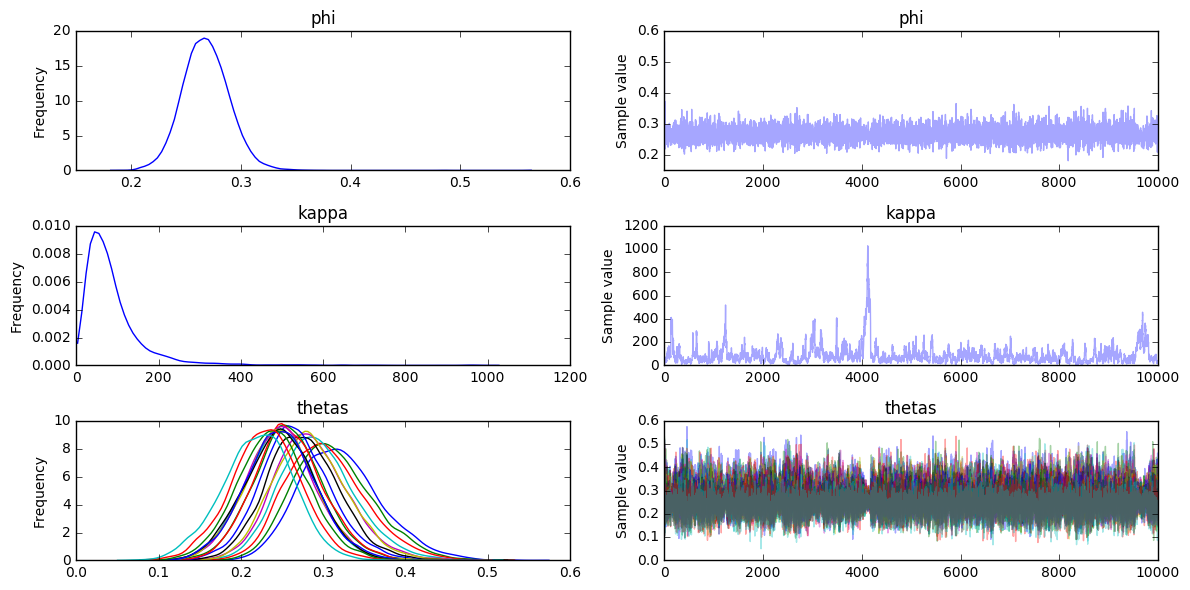

In [16]:
pm.traceplot( trace )

The plots provide a lots of information. Notice the estimated global average performance -- where it is peaked and how wide is it. Similarly, notice the thetas -- one for each of the player.

The right hand size plots are more for diagnostics. One wants a steady "band" of sample values without sudden jumps and deviations. In case of problems, one might need to check how well behaved these plots are.

## Conclusion
The notebook only barely scratched the subject of hierarchical models. The outlined approach & code can serve as a starting point for modeling various applications where repeated binomial trials are executed. For example, estimating performances of N classifiers on some problem given their respective correct predictions (and the number of total of predictions).